# SGD Classifier

In [285]:
import pickle
import numpy as np
import pandas as pd
import scikitplot as skplt
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction import stop_words
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

# Keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.estimator import DNNClassifier
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

use https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

### Load data

In [286]:
df = pd.read_csv("data/mixed_data_1200.csv", sep=';')
df = df.drop(["Unnamed: 0"],axis=1)
df.head(5)

,target,text
0,0,@Starrbby too bad I won't be around I lost my ...
1,0,amazon s3 plugin not worked in my website . it...
2,0,The Hoyts Distribution NZ website isn't workin...
3,0,dang won't be able to get to any workshops run...
4,0,Tried to install a Twitter-application on my p...


In [327]:
df.head(5)
#converts whitespaces
trb_nan_idx = df[pd.isnull(df['text'])].index.tolist()
df.loc[trb_nan_idx, 'text'] = ' '
X_load = df["text"]
Y_load = df["target"]

dicc = {0:0,2:1,4:2}
Y_load = Y_load.map(dicc)

In [328]:
print(len(stop_words.ENGLISH_STOP_WORDS))
stopwords = stop_words.ENGLISH_STOP_WORDS

318


### Tokenize data

In [329]:
X_traink ,X_testk, y_traink, y_testk = train_test_split(X_load,Y_load,test_size=0.2,random_state=42,shuffle=True)

tokenizer = Tokenizer(lower=True,filters = "!\"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n", split = " ")
tokenizer.fit_on_texts(X_traink)

In [330]:
average_length = np.mean([len(x) for x in X_traink])
median_length = sorted([len(x) for x in X_traink])[len(X_traink) // 2]

print(average_length)
print(median_length)

65.27160927617709
59


In [331]:
type(X_traink)

pandas.core.series.Series

In [332]:
X_traink = tokenizer.texts_to_sequences(X_traink)
X_testk = tokenizer.texts_to_sequences(X_testk)
vocab_size = #len(X_traink)

In [334]:
max_sequence_length = 80
X_traink = pad_sequences(X_traink,maxlen=max_sequence_length,padding="post", truncating='post',dtype='int32',value=0.)
X_testk = pad_sequences(X_testk,maxlen=max_sequence_length,padding="post", truncating='post',dtype='int32',value=0.)

In [360]:
#export TFHUB_CACHE_DIR="/Users/ChrisChross/Desktop/Sentiment Code"
m = hub.Module("/Users/ChrisChross/Desktop/Sentiment Code")
embed = hub.load("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1")

RuntimeError: Missing implementation that supports: loader(*('/Users/ChrisChross/Desktop/Sentiment Code',), **{})

In [349]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", output_shape=[20],
                           input_shape=[], dtype=tf.string)

OSError: SavedModel file does not exist at: /var/folders/dq/2sbny7gx0z36pxh0m5vqw7v00000gn/T/tfhub_modules/510580b203329a4a95dfdfefd838bdcd202f0d13/{saved_model.pbtxt|saved_model.pb}

In [346]:
hidden_size = 32

sl_model = Sequential()
sl_model.add(Embedding(max_words, hidden_size))
sl_model.add(LSTM(hidden_size, activation='relu', dropout=0.4, recurrent_dropout=0.4))
sl_model.add(Dense(1, activation='sigmoid'))
sl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10

sl_model.fit(X_traink, y_traink, epochs=epochs, shuffle=True)
loss, acc = sl_model.evaluate(X_testk, y_testk)
print('Single layer model -- ACC {} -- LOSS {}'.format(acc, loss))

Train on 2846 samples
Epoch 1/10
2846/2846 [==============================] - 5s 2ms/sample - loss: 0.1899 - accuracy: 0.3356
Epoch 2/10
2846/2846 [==============================] - 4s 1ms/sample - loss: 0.0158 - accuracy: 0.3387
Epoch 3/10
2846/2846 [==============================] - 4s 1ms/sample - loss: 0.2890 - accuracy: 0.3363
Epoch 4/10
2846/2846 [==============================] - 4s 1ms/sample - loss: 0.2297 - accuracy: 0.3387
Epoch 5/10
2846/2846 [==============================] - 5s 2ms/sample - loss: 0.2313 - accuracy: 0.3387
Epoch 6/10
2846/2846 [==============================] - 4s 2ms/sample - loss: 0.2383 - accuracy: 0.3366
Epoch 7/10
2846/2846 [==============================] - 4s 1ms/sample - loss: 0.2654 - accuracy: 0.3338
Epoch 8/10
2846/2846 [==============================] - 4s 1ms/sample - loss: 0.0926 - accuracy: 0.3359
Epoch 9/10
2846/2846 [==============================] - 4s 1ms/sample - loss: 0.0086 - accuracy: 0.3377
Epoch 10/10
712/712 [=====================

In [342]:
d_model = Sequential()
d_model.add(Embedding(max_words, hidden_size))
d_model.add(LSTM(hidden_size, activation='tanh', dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
d_model.add(LSTM(hidden_size, activation='tanh', dropout=0.2, recurrent_dropout=0.2))
d_model.add(Dense(1, activation='sigmoid'))
d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
d_model.fit(X_traink, y_traink, epochs=epochs, shuffle=True)
d_loss, d_acc = d_model.evaluate(X_testk, y_testk)
print('Double layer model -- ACC {} -- LOSS {}'.format(d_acc, d_loss))

Train on 2846 samples
Epoch 1/10
2846/2846 [==============================] - 9s 3ms/sample - loss: 0.0508 - accuracy: 0.3401
Epoch 2/10
2846/2846 [==============================] - 8s 3ms/sample - loss: -0.1001 - accuracy: 0.3387
Epoch 3/10
2846/2846 [==============================] - 8s 3ms/sample - loss: -0.1171 - accuracy: 0.3387
Epoch 4/10
2846/2846 [==============================] - 9s 3ms/sample - loss: -0.1304 - accuracy: 0.3387
Epoch 5/10
2846/2846 [==============================] - 8s 3ms/sample - loss: -0.1376 - accuracy: 0.3387
Epoch 6/10
2846/2846 [==============================] - 8s 3ms/sample - loss: -0.1460 - accuracy: 0.3387
Epoch 7/10
2846/2846 [==============================] - 10s 4ms/sample - loss: -0.1533 - accuracy: 0.3387
Epoch 8/10
2846/2846 [==============================] - 10s 3ms/sample - loss: -0.1555 - accuracy: 0.3387
Epoch 9/10
2846/2846 [==============================] - 14s 5ms/sample - loss: -0.1616 - accuracy: 0.3387
Epoch 10/10
712/712 [==========

In [247]:
#summarize what was learned
#print(tokenizer.word_counts) #word_counts: A dictionary of words and their counts.
#print(tokenizer.document_count) #document_count:An integer count of the total number of documents that were used to fit the Tokenizer.
#print(tokenizer.word_index) #word_index: A dictionary of words and their uniquely assigned integers.
#print(tokenizer.word_docs) #word_docs: A dictionary of words and how many documents each appeared in.

In [248]:
# integer encode documents // standard bag-of-words of length vocab size => len(t.word_index) = 7282
#encoded_tweets = tokenizer.texts_to_matrix(X_load, mode='tfidf') #binary / count / tfidf / freq
X_traink = tokenizer.texts_to_matrix(X_traink, mode='tfidf') #binary / count / tfidf / freq
X_testk = tokenizer.texts_to_matrix(X_testk, mode='tfidf') 

In [163]:
num_classes = max(y_traink+1)
print(num_classes)
y_traink = tf.keras.utils.to_categorical(y_traink,num_classes=3)
y_testk = tf.keras.utils.to_categorical(y_testk,num_classes=3)

3


In [164]:
print(y_traink)
print(y_testk)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]
[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [336]:
max_words = 6465
model = Sequential()
model.add(Dense(128,input_shape=(6465, )))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [142]:
batch_size = 10
epochs = 5

_ = model.fit(X_traink,y_traink,batch_size=batch_size,epochs=epochs,verbose=1,validation_split=0.1)
scores = model.evaluate(X_testk,y_testk,batch_size=batch_size,verbose=1)

print("Accuracy is: {}".format(scores[1]))

Train on 2561 samples, validate on 285 samples
Epoch 1/5
2561/2561 [==============================] - 3s 1ms/sample - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.5173 - val_accuracy: 0.8842
Epoch 2/5
2561/2561 [==============================] - 3s 1ms/sample - loss: 0.0011 - accuracy: 0.9992 - val_loss: 0.5184 - val_accuracy: 0.8877
Epoch 3/5
2561/2561 [==============================] - 3s 1ms/sample - loss: 0.0012 - accuracy: 0.9992 - val_loss: 0.5248 - val_accuracy: 0.8877
Epoch 4/5
2561/2561 [==============================] - 3s 1ms/sample - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.5275 - val_accuracy: 0.8912 0.0012 - accu
Epoch 5/5
712/712 [==============================] - 0s 526us/sample - loss: 0.3545 - accuracy: 0.9129
Accuracy is: 0.9129213690757751


In [49]:
dfidf_df = pd.DataFrame(data=encoded_tweets)
#dfidf_df.to_latex()

In [20]:
#dflatex1 = dfidf_df.iloc[[0,1,2,3,-3,-2,-1], [0,1,2,3,-3,-2,-1]]
#print(dflatex1.to_latex())

In [25]:
print(len(encoded_tweets))
len(encoded_tweets[0]) #with length of voab size

3558


7439

In [24]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items())) #reverse_word_map

# Function takes a tokenized sentence and returns the words
def sequence_to_text(list_of_indices):
    # Looking up words in dictionary
    #words = [reverse_word_map.get(list_of_indices.indexOf(letter)) for letter in list_of_indices if letter>0]
    words = []
    count = 0
    for letter in list_of_indices:
        if letter >0:
            words.append(reverse_word_map.get(count))
        count+=1
        #print(count)
    return(words)

text = encoded_tweets[0]
print(text)
# Creating texts 
my_texts =  list(map(sequence_to_text, [encoded_tweets[0]]))
' '.join(my_texts[0])

[0. 0. 0. ... 0. 0. 0.]


"i my and phone be can't too job won't bad even lost pay around bill aw starrbby lmao shucks"

### Split data into train/test set

In [33]:
X_load = df["text"]
Y_load = df["target"]
X_train,X_test,y_train,y_test = train_test_split(X_load,Y_load,test_size=0.2,random_state=42,shuffle=True)

### Vectorize Data

In [254]:
count_vect = CountVectorizer(stop_words='english',ngram_range=(1, 1))
X_train_counts = count_vect.fit_transform(X_train.values.astype('U'))
X_test_counts = count_vect.transform(X_test.values.astype('U'))
X_train_counts.shape

(2846, 6033)

### TF-IDF Data

In [255]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_train_tfidf.shape

(2846, 6033)

### Train model

In [256]:
svmClassifier =  SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
svmClassifier.fit(X_train_tfidf, y_train)
svm = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)
svm.fit(X_traink, y_train)

/Users/ChrisChross/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

### Predict
use the unlabled data

In [257]:
predictions = svmClassifier.predict(X_test_tfidf)
predictions2 = svm.predict(X_testk)

In [258]:
xxx = ["Today my PC crashed what a shit I can not work I am so stressed"]

In [259]:
xxx1 = count_vect.transform(xxx)
xxx2 = tfidf_transformer.transform(xxx1)
pred = svmClassifier.predict(xxx2)
pred

array([0])

### Evaluate

In [260]:
np.mean(predictions == y_test) #accuracy

0.9157303370786517

In [261]:
np.mean(predictions2 == y_testk) #accuracy

0.9199438202247191

In [269]:
print(metrics.classification_report(y_test, predictions,target_names=["techno-stress","neutral","positive"]))
report = metrics.classification_report(y_test, predictions,target_names=["techno-stress","neutral","positive"],output_dict=True)
reportdf = pd.DataFrame(report).transpose()
print(reportdf.to_latex())

               precision    recall  f1-score   support

techno-stress       0.96      0.99      0.97       268
      neutral       0.83      0.98      0.90       222
     positive       0.98      0.77      0.86       222

    micro avg       0.92      0.92      0.92       712
    macro avg       0.92      0.91      0.91       712
 weighted avg       0.93      0.92      0.91       712

\begin{tabular}{lrrrr}
\toprule
{} &  f1-score &  precision &    recall &  support \\
\midrule
techno-stress &  0.972376 &   0.960000 &  0.985075 &    268.0 \\
neutral       &  0.897119 &   0.825758 &  0.981982 &    222.0 \\
positive      &  0.860759 &   0.982659 &  0.765766 &    222.0 \\
micro avg     &  0.915730 &   0.915730 &  0.915730 &    712.0 \\
macro avg     &  0.910085 &   0.922806 &  0.910941 &    712.0 \\
weighted avg  &  0.914109 &   0.925209 &  0.915730 &    712.0 \\
\bottomrule
\end{tabular}



#### Learning Curve

/Users/ChrisChross/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/ChrisChross/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


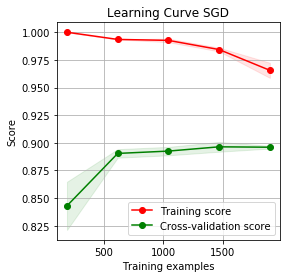

In [265]:
learn1 = skplt.estimators.plot_learning_curve(svmClassifier, X_train_tfidf, y_train,figsize=(4,4))
plt.title("Learning Curve SGD")
plt.show()

#### Confusion Matrix 

<Figure size 432x288 with 0 Axes>

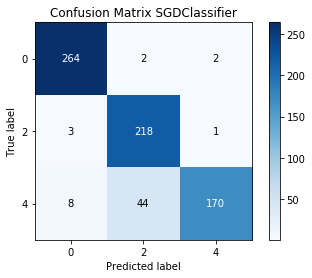

In [267]:
plt.figure()
skplt.metrics.plot_confusion_matrix(y_test,predictions,normalize=False)
#cnf_matrix = metrics.confusion_matrix(y_test, predictions)
plt.title("Confusion Matrix SGDClassifier")
plt.show()